In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools as ft

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from IPython.display import display

import kelp_compute

sp.init_printing()
%matplotlib inline

from fortran_wrappers.pykelp3d_wrap import pykelp3d_wrap as f90
f90.solve_rte_with_callbacks?

In [3]:
space = sp.var('x, y, z')
x, y, z = space
vec_x = sp.Matrix(space)

angle = sp.var(r'theta, phi')
th, ph = angle
vec_om = sp.Matrix([sp.sin(ph)*sp.cos(th), sp.sin(ph)*sp.sin(th), sp.cos(ph)])
delta = sp.var(r'Delta')

angle_prime = sp.var(r'theta_p, phi_p')
thp, php = angle_prime
vec_omp = sp.Matrix([sp.sin(php)*sp.cos(thp), sp.sin(php)*sp.sin(thp), sp.cos(php)])

In [4]:
def grad(expr, space=space):
    return sp.Matrix([sp.diff(expr, d) for d in space])

In [5]:
def sphere_integral(expr, angle):
    theta, phi = angle
    return sp.integrate(expr*sp.sin(phi), (theta, 0, 2*sp.pi), (phi, 0, sp.pi))

In [6]:
def dot(a, b):
    return sum(a.T * b)

In [619]:
def p_hat(l, m):
    if m == 0:
        p = 0
    elif m == na:
        p = nomega
    else:
        p = (m_pi_over_4-1)*na + l_zero + 1
        
    return p

In [623]:
def vec_l(vec_x, vec_omega, s, zmax):
    z_hat = sp.Matrix([0,0,1])
    z0 = sp.Piecewise(
        (0, dot(vec_omega, z_hat) > 0),
        (zmax, True)
    )
    s_tilde = (dot(vec_x, z_hat) - z0) / dot(vec_omega, z_hat)
    vec_x0 = vec_x - s_tilde * vec_omega
    vec_l = (s*vec_x + (s_tilde-s)*vec_x0) / s_tilde
    return vec_l

In [717]:
def vec_l0(vec_x0, vec_omega, s, zmax):
    z_hat = sp.Matrix([0,0,1])
    z0 = sp.Piecewise(
        (0, dot(vec_omega, z_hat) > 0),
        (zmax, True)
    )
    s_tilde = (zmax - z0) / dot(vec_omega, z_hat)
    vec_x1 = vec_x0 + s_tilde * vec_omega
    vec_l = (s*vec_x1 + (s_tilde-s)*vec_x0) / s_tilde
    return vec_l

In [7]:
def gen_grid(ns, nz, na, rope_spacing, zmax):
    ds = rope_spacing/ns
    dz = zmax/nz
    
    x = y = -rope_spacing/2 + ds * (np.arange(ns) + 1/2)
    z = dz * (np.arange(nz) + 1/2)
    
    ntheta = nphi = na
    nomega = ntheta*(nphi-2) + 2
    
    dtheta = 2*np.pi/ntheta
    dphi = np.pi/(nphi-1)
    
    theta = dtheta * np.arange(ntheta)
    phi = dphi * np.arange(nphi)

    l = np.arange(ntheta)
    m = np.arange(nphi)
    p = np.arange(nomega)

    L, M = np.meshgrid(l, m, indexing='ij')
    
    phat = (M-1)*ntheta + L + 1
    phat[:,0] = 0
    phat[:,-1] = nomega-1
    
    theta_p = np.zeros(nomega)
    phi_p = np.zeros(nomega)
    theta_p[phat] = theta[L]
    theta_p[0] = theta_p[-1] = 0
    phi_p[phat] = phi[M]
    
    # A bit redundant, but seems to work
    X, Y, Z, Theta = np.meshgrid(x, y, z, theta_p, indexing='ij')
    _, _, _, Phi = np.meshgrid(x, y, z, phi_p, indexing='ij')
    
    return X, Y, Z, Theta, Phi

In [316]:
def display_eq(lhs_name, rhs_expr):
    """
    Use IPython.display.display to display a symbolic equation
    """
    display(sp.Eq(sp.Symbol(lhs_name), rhs_expr))

In [612]:
def subs_dict(expr, param_dict):
    """
    Substitute a dictionary of values into a symbolic expression.
    """
    # Multiply by a placeholder symbol to the expression in case it is originally
    # just a numeric constant, in which case .subs fails.
    placeholder = sp.Symbol('PLACEHOLDER')
    new_expr = expr * placeholder
    for key, val in param_dict.items():
        new_expr = new_expr.subs(key, val)
        
    # Set the placeholder symobol to one.
    new_expr = new_expr.subs(placeholder, 1)
    
    return new_expr

In [366]:
def symify(expr, *args, **subs):
    """
    Create symbolic sympy function from `expr`,
    with `args` as free variables, 
    and `subs` values as fixed constants.
    """
    return sp.lambdify(
        args,
        subs_dict(expr, subs),
        modules=("sympy",)
    )

---

## Calculation functions

In [368]:
def calculate_bc(L, params=()):
    z = space[-1]
    zmin = 0
    return L(*space, *angle, *params).subs(z, zmin)

In [367]:
def calculate_source(L, b, a, beta, params=()):
    L_om = L(*space, *angle, *params)
    L_omp = L(*space, *angle_prime, *params)
    
    deriv = dot(vec_om, grad(L_om))
    atten = (a(*space)+b)*L_om
    
    scat_integrand = beta(dot(vec_om, grad(L_omp))) * L_omp
    scat = b * sphere_integral(scat_integrand, angle=angle_prime)
    
    source = deriv + atten - scat
    
    return source

In [499]:
def check_sol(L, b, a, beta, sigma):
    L_om = L(*space, *angle)
    L_omp = L(*space, *angle_prime)
    
    deriv = dot(vec_om, grad(L_om))
    atten = (a(*space)+b)*L_om
    
    scat_integrand = beta(dot(vec_om, grad(L_omp))) * L_omp
    scat = b * sphere_integral(scat_integrand, angle=angle_prime)
    
    source = sigma(*space, *angle)
    
    return deriv + atten - scat - source

---

## User-function definitions

In [484]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [485]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        *(2+sp.sin(phi))
    )

In [486]:
def uniform_L(x, y, z, theta, phi, alpha, gamma):
    return alpha

In [487]:
def tanh_L(x, y, z, theta, phi, alpha, gamma):
    return alpha * sp.tanh(gamma-z)

In [488]:
# TODO: Should be periodic on correct grid
def prod_a(x, y, z):
    return (2+sp.sin(2*sp.pi*x))*(2+sp.sin(2*sp.pi*y))*(1+sp.tanh(z-gamma))

In [489]:
def uniform_a(x, y, z):
    return 1

### Decide here which functions to use.

In [731]:
sol_func = tanh_L
abs_func = uniform_a
vsf_func = uniform_vsf

---

## Calculate source & BC

In [732]:
b = sp.var('b')
params = sp.var('alpha, gamma')

source_expr = calculate_source(sol_func, b, abs_func, vsf_func, params)
bc_expr = calculate_bc(sol_func, params)

# Evaluate other expressions as well for consistency
sol_expr = sol_func(*space, *angle, *params)
abs_expr = abs_func(*space)
vsf_expr = vsf_func(delta)

## Specify parameter values

In [733]:
alpha = 1
gamma = 1
b = 0.0
param_vals = {
    'alpha': alpha,
    'gamma': gamma,
    'b': b
}

## Generate symbolic and numerical functions

In [734]:
source_sym = symify(source_expr, *space, *angle, **param_vals)
abs_sym = symify(abs_expr, *space, **param_vals)
bc_sym = symify(bc_expr, *angle, **param_vals)
sol_sym = symify(sol_expr, *space, *angle, **param_vals)
vsf_sym = symify(vsf_expr, delta, **param_vals)

# Generate numerical functions
abs_func_N = kelp_compute.sym_to_num(abs_sym, *space)
source_func_N = kelp_compute.sym_to_num(source_sym, *space, *angle)
bc_func_N = kelp_compute.sym_to_num(bc_sym, *angle)
vsf_func_N = kelp_compute.sym_to_num(vsf_sym, delta)
sol_func_N = kelp_compute.sym_to_num(sol_sym, *space, *angle)

## Problem Summary

In [735]:
print("Solution")
display_eq('L', sol_sym(*space, *angle))
print()

print("Absorption Coefficient")
display_eq('a', abs_sym(*space))
print()

print("Boundary Condition")
display_eq('L_0', bc_sym(*angle))
print()

print("Source")
display_eq('sigma', source_sym(*space, *angle))
print()

Solution



Absorption Coefficient



Boundary Condition



Source


## Check solution constraints

- Everything is periodic in x, y
- Absorption coefficient is positive
- Boundary condition depends only on angle
- No upwelling light from below

## Check source term

Source term seems too high, so try substituting parameters,
then plugging in analytical solution.

The result should be 0.

In [736]:
check_sol(sol_sym, b, abs_sym, vsf_sym, source_sym)

## Numerical Solution

In [737]:
# Grid options
ns = 20
nz = 20
na = 10
nomega = na*(na-2) + 2
rope_spacing = 1
zmax = 1

# Solver options
lis_opts = "-i gmres"
fd_flag = False
num_scatters = 0

# Calculate numerical solution
scalar_params, results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, bc_sym, vsf_sym,
    num_scatters, fd_flag, lis_opts
)

# Extract numerical solution
asymptotic_sol = results['rad']

# Evaluate true solution on same grid
x, y, z, theta, phi = gen_grid(ns, nz, na, rope_spacing, zmax)
true_sol = sol_func_N(x, y, z, theta, phi)

In [738]:
# Pick one angle to evaluate symbolically and plot
l = 0
m = int(np.floor(na/4))
p = p_hat(l, m)
th = theta[0,0,0,p]
ph = phi[0,0,0,p]
one_angle_dict = {
    'theta': th,
    'phi': ph
}
one_angle_tuple = (th, ph)

## Symbolic Solution (no scattering)

In [739]:
s, s_p, s_pp = sp.var('s, s_p, s_{pp}')
x0, y0 = sp.var('x_0, y_0')
vec_x0 = sp.Matrix([x0, y0, 0])

In [740]:
a_tilde = abs_sym(
    *sp.simplify(
        subs_dict(
            vec_l0(vec_x0, vec_om, s_pp, zmax),
            one_angle_dict
        )
    )
)

sigma_tilde = source_sym(
    *sp.simplify(
        subs_dict(
            vec_l0(vec_x0, vec_om, s_p, zmax),
            one_angle_dict
        )
    ), 
    *one_angle_tuple
)

In [741]:
a_tilde

In [742]:
sigma_tilde

In [743]:
u0_s = sp.integrate(
    sigma_tilde * sp.exp(
        -sp.integrate(
            a_tilde,
            (s_pp, s_p, s)
        )
    ),
    (s_p, 0, s)
)

In [744]:
u0_s

In [747]:
u0_func = sp.lambdify(
    ('s', 'x_0', 'y_0'),
    u0_s,
    modules=("sympy",)
)

In [755]:
L_symbolic_expr = u0_func(
    sp.Symbol('z')*sp.sec(ph),
    sp.Symbol('x') - sp.Symbol('z')*sp.tan(ph)*sp.cos(th),
    sp.Symbol('y') - sp.Symbol('z')*sp.tan(ph)*sp.sin(th),
)

L_symbolic_N = sp.lambdify(
    space,
    L_symbolic_expr,
    modules=("numpy",)
)

symbolic_sol = L_symbolic_N(x, y, z)

In [756]:
L_symbolic_expr

## Plot

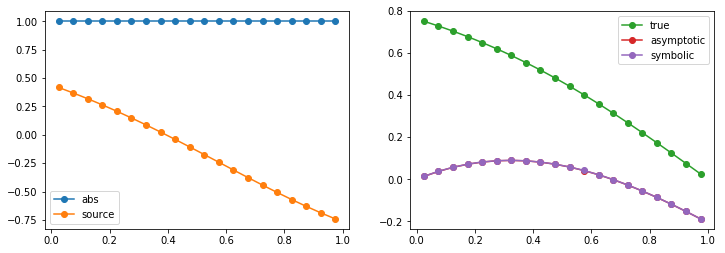

In [758]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(z[0,0,:,p], abs_func_N(x,y,z)[0,0,:,p], 'C0o-', label='abs')
plt.plot(z[0,0,:,p], source_func_N(x,y,z,theta,phi)[0,0,:,p], 'C1o-', label='source')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z[0,0,:,p], true_sol[0,0,:,p], 'C2o-', label='true')
plt.plot(z[0,0,:,p], asymptotic_sol[0,0,:,p], 'C3o-', label='asymptotic')
plt.plot(z[0,0,:,p], symbolic_sol[0,0,:,p], 'C4o-', label='symbolic')
plt.legend()

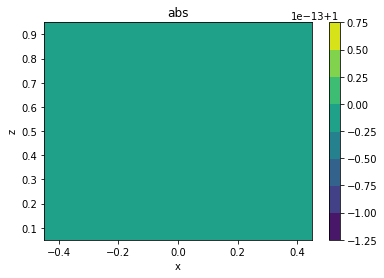

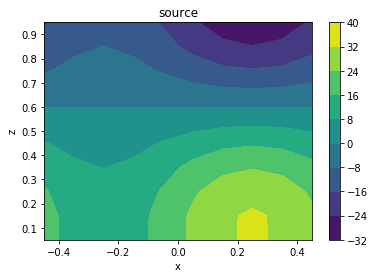

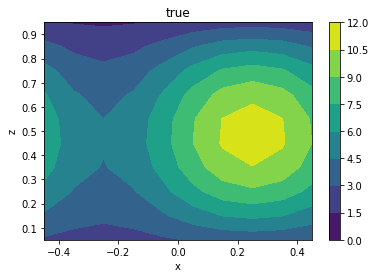

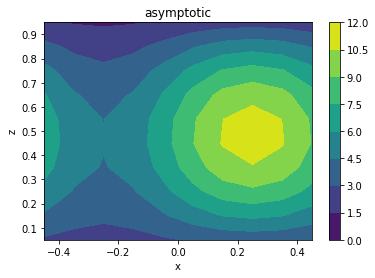

In [518]:
plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], abs_func_N(x,y,z)[:,0,:,0])
plt.colorbar()
plt.title('abs')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], source_func_N(x,y,z,theta,phi)[:,0,:,0,])
plt.colorbar()
plt.title('source')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], true_sol[:,0,:,0])
plt.colorbar()
plt.title('true')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], asymptotic_sol[:,0,:,0])
plt.colorbar()
plt.title('asymptotic')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

---

In [69]:
def print_stats(x):
    print("min:", np.min(x))
    print("max:", np.max(x))
    print("mean:", np.mean(x))

In [70]:
print("abs:")
print_stats(abs_func_N(x, y, z))
print()

print("source:")
print_stats(source_func_N(x, y, z, theta, phi))
print()

print("bc:")
print_stats(bc_func_N(theta, phi))
print()

abs:
min: 1
max: 1
mean: 1.0

source:
min: -0.9987255736300098
max: 0.9987255736300098
mean: -9.238213197532601e-17

bc:
min: 0.7615941559557649
max: 0.7615941559557649
mean: 0.7615941559557646

